In [83]:
import numpy as np
import pandas as pd
import datetime
import geopandas as gpd
pd.set_option("display.max_colwidth", 0)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
pd.options.display.float_format = '{:.5f}'.format
import warnings
warnings.filterwarnings("ignore")
# %pip install contextily

import matplotlib.colors as mcolors
from shapely.geometry import Point
from geopandas import GeoDataFrame

In [84]:
%%time
df_shap = pd.read_csv("./output/food_localness_final_oct_new_shap_values.csv", sep=",", header=0)
df_shap = df_shap.drop(columns=['account_id','customer_lon','customer_lat','vendor_id','vendor_lon','vendor_lat'])
print(df_shap.shape[0])

df_localness = pd.read_csv('./data/food_localness_final_oct_new.csv')
print(df_localness.shape[0])

df_shap.head()

2782961
2782961
CPU times: user 33.6 s, sys: 9.71 s, total: 43.3 s
Wall time: 48.7 s


,order_id,shap_customer_lon,shap_customer_lat,shap_basket_amount_lc,shap_price_per_item,shap_order_time_hour,shap_total_duration,shap_estimated_rent,shap_entropy_0.5km,shap_entropy_2km,shap_entropy_5km,shap_incentive_amount_lc,shap_incentive_delivery,shap_incentive_menu_discount,shap_incentive_voucher_wallet,shap_main_cuisine,shap_isweekend,shap_consistency,shap_total_orders,shap_rating,shap_n_rating,shap_restaurant_count_0.5km,shap_restaurant_count_0.5_1km,shap_restaurant_count_1_2km,shap_restaurant_count_2_3km,shap_restaurant_count_3_4km,shap_restaurant_count_4_5km
0,1304769890,0.00244,-0.03897,-0.00028,-0.02471,-0.00229,-0.04369,-0.02285,-0.01160,-0.00625,-0.00795,-0.00693,-0.00033,0.02653,0.00202,0.00742,-0.00204,0.00037,-0.00279,0.00573,-0.00109,-0.06651,-0.03507,-0.01015,0.01161,0.01675,0.00551
1,1304769334,0.01427,-0.03612,0.00361,-0.02855,0.00483,-0.03982,-0.02054,-0.01239,-0.00023,-0.00232,-0.00685,0.00014,0.01728,0.00126,0.01885,-0.00188,-0.00665,-0.00085,0.00260,0.00686,-0.05904,-0.03352,-0.01552,0.00733,0.01859,0.00347
2,1306219965,-0.00252,-0.05946,-0.00322,0.00930,0.01813,0.02248,-0.00287,-0.01851,-0.00096,-0.01496,-0.00094,0.00111,-0.00416,-0.00079,-0.00118,-0.00111,-0.00214,-0.00526,0.01110,0.02437,-0.07212,-0.01681,-0.00032,0.01517,0.00119,0.00573
3,1295994041,-0.00478,-0.05750,0.00276,0.01482,0.02477,0.05165,-0.00512,-0.01873,-0.00935,-0.01426,-0.00162,0.00110,-0.00737,-0.00060,0.00548,-0.00154,-0.00285,-0.00522,0.01170,0.02524,-0.07027,-0.01217,0.00458,0.02032,-0.00329,0.00297
4,1304742536,-0.00298,-0.01597,-0.00942,-0.01524,-0.00169,-0.03153,-0.00766,-0.04734,-0.01768,-0.01196,-0.02107,-0.01327,0.02753,-0.00012,-0.01432,-0.00123,-0.00099,0.00014,-0.03158,-0.01439,-0.07016,-0.02167,-0.00915,0.00254,-0.00010,-0.00205


In [85]:
df_shap_merged = df_localness.merge(df_shap, on='order_id')
print(df_shap_merged.shape[0])

2782961


# (Optional) Quadrant plot

In [5]:
selected_feature = 'estimated_rent'
# Some continuous features to be considered: estimated_rent, incentive_amount_lc, entropy_0.5km, restaurant_count_0.5km,
# price_per_item, order_time_hour, basket_amount_lc, total_orders, consistency, incentive_delivery
# incentive_menu_discount, incentive_voucher_wallet

benchmark = df_shap_merged[selected_feature].median()
df_shap_need = df_shap_merged[[selected_feature,'shap_'+selected_feature]]
df_shap_need.loc[(df_shap_need[selected_feature]>=benchmark) & (df_shap_need['shap_'+selected_feature]>0),'Quadrant'] = 'High-Positive'
df_shap_need.loc[(df_shap_need[selected_feature]>=benchmark) & (df_shap_need['shap_'+selected_feature]<=0),'Quadrant'] = 'High-Negative'
df_shap_need.loc[(df_shap_need[selected_feature]<benchmark) & (df_shap_need['shap_'+selected_feature]>0),'Quadrant'] = 'Low-Positive'
df_shap_need.loc[(df_shap_need[selected_feature]<benchmark) & (df_shap_need['shap_'+selected_feature]<=0),'Quadrant'] = 'Low-Negative'
print(df_shap_need.Quadrant.value_counts())

Low-Negative     819192
High-Negative    786456
High-Positive    605028
Low-Positive     572285
Name: Quadrant, dtype: int64


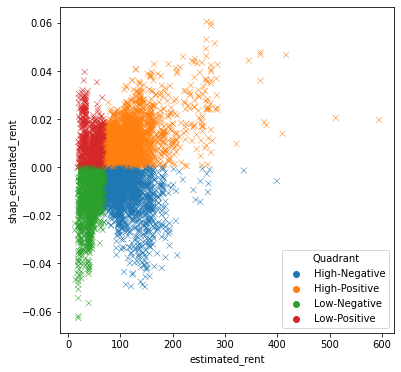

CPU times: user 2.22 s, sys: 1.33 s, total: 3.55 s
Wall time: 3.51 s


In [6]:
%%time
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.scatterplot(data=df_shap_need.head(10000), 
                x=selected_feature, 
                y='shap_'+selected_feature, 
                hue="Quadrant", 
                marker='x')  # Use marker='x' here
plt.show()

# 1. Hexagon - best visualization for 2 million points

,index,geometry
h3_polyfill,,
8843ac58b3fffff,0,"POLYGON ((55.65216 25.03748, 55.65389 25.03319, 55.65899 25.03205, 55.66236 25.03520, 55.66062 25.03949, 55.65552 25.04063, 55.65216 25.03748))"
8843ae9459fffff,0,"POLYGON ((55.57713 24.91382, 55.57887 24.90953, 55.58396 24.90840, 55.58731 24.91154, 55.58557 24.91583, 55.58048 24.91696, 55.57713 24.91382))"
8843a12e09fffff,0,"POLYGON ((55.37812 24.99315, 55.37987 24.98887, 55.38497 24.98774, 55.38831 24.99089, 55.38656 24.99518, 55.38147 24.99630, 55.37812 24.99315))"
8843ac4347fffff,0,"POLYGON ((55.61760 25.09987, 55.61934 25.09558, 55.62445 25.09444, 55.62781 25.09760, 55.62607 25.10189, 55.62097 25.10303, 55.61760 25.09987))"
8843acc0a1fffff,0,"POLYGON ((55.41893 25.37083, 55.42069 25.36653, 55.42581 25.36540, 55.42918 25.36857, 55.42742 25.37288, 55.42230 25.37401, 55.41893 25.37083))"


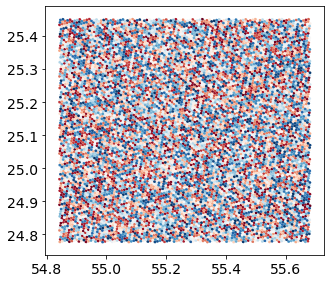

In [86]:
from shapely.geometry import box

bound_lat = [24.776468,25.451666]
bound_lon = [54.842954,55.680861] # 25.637066, 55.849584 

dubai_box = gpd.GeoDataFrame(geometry=[box(bound_lon[0],bound_lat[0],bound_lon[1],bound_lat[1])],crs="EPSG:4326")
# %pip install h3pandas
# create hexagon within the UAE border
import geopandas as gpd
import h3pandas

resolution = 8 # Average edge length: 500m
hexagons = dubai_box.h3.polyfill_resample(resolution)
ax = hexagons.plot(figsize=(5, 5), cmap='RdBu')
hexagons.head()

In [80]:
%%time

selected_feature = 'restaurant_count_4_5km'
# Some continuous features to be considered: estimated_rent, incentive_amount_lc, entropy_0.5km, entropy_2km, entropy_5km,
# restaurant_count_0.5km, restaurant_count_0.5_1km, restaurant_count_1_2km, restaurant_count_2_3km, restaurant_count_3_4km, restaurant_count_4_5km
# price_per_item, order_time_hour, basket_amount_lc, total_orders, consistency, incentive_delivery
# incentive_menu_discount, incentive_voucher_wallet

df_onefeature = df_shap_merged[['account_id','order_id','customer_lon','customer_lat', selected_feature,'shap_'+selected_feature]]
# df_onefeature = df_onefeature[df_onefeature['incentive_amount_lc']<=10]
geometry2 = [Point(xy) for xy in zip(df_onefeature.customer_lon, df_onefeature.customer_lat)]
gdf_onefeature = GeoDataFrame(df_onefeature, crs="EPSG:4326", geometry=geometry2)
# gdf_test = gdf_onefeature.head(1000)
# gdf_test.head()

CPU times: user 16.2 s, sys: 303 ms, total: 16.5 s
Wall time: 16.4 s


In [81]:
%%time
mean_hex = gpd.sjoin(gdf_onefeature, hexagons, op='within') 
hexagon_agg = mean_hex[['index_right',selected_feature,'shap_'+selected_feature]].groupby('index_right').agg('mean')
hexagon_agg_ordernumber = hexagons.merge(hexagon_agg,left_index=True,right_index=True) # focus on hexagons that contains delivery data
print(hexagon_agg_ordernumber.shape[0])
# hexagon_agg_ordernumber.head()

# hexagon_agg_ordernumber[selected_feature].hist()
# df_shap_merged[selected_feature].median()
print(hexagon_agg_ordernumber[selected_feature].describe())

benchmark = hexagon_agg_ordernumber[selected_feature].median()
print('We use feature median values:',benchmark,'to distinguish High and Low feature values!!!!')
shap_threshold = 0.00

hexagon_agg_ordernumber.loc[(hexagon_agg_ordernumber[selected_feature]>=benchmark) & (hexagon_agg_ordernumber['shap_'+selected_feature]>shap_threshold),'Quadrant'] = 'High-Positive'
hexagon_agg_ordernumber.loc[(hexagon_agg_ordernumber[selected_feature]>=benchmark) & (hexagon_agg_ordernumber['shap_'+selected_feature]<=-1*shap_threshold),'Quadrant'] = 'High-Negative'
hexagon_agg_ordernumber.loc[(hexagon_agg_ordernumber[selected_feature]<benchmark) & (hexagon_agg_ordernumber['shap_'+selected_feature]>shap_threshold),'Quadrant'] = 'Low-Positive'
hexagon_agg_ordernumber.loc[(hexagon_agg_ordernumber[selected_feature]<benchmark) & (hexagon_agg_ordernumber['shap_'+selected_feature]<=-1*shap_threshold),'Quadrant'] = 'Low-Negative'
print(hexagon_agg_ordernumber.Quadrant.value_counts())
hexagon_agg_ordernumber.head()

1351
count   1351.00000
mean    121.25778 
std     106.15292 
min     0.00000   
25%     26.47520  
50%     103.48765 
75%     180.60436 
max     573.28451 
Name: restaurant_count_4_5km, dtype: float64
We use feature median values: 103.48764769065521 to distinguish High and Low feature values!!!!
High-Negative    497
Low-Positive     354
Low-Negative     321
High-Positive    179
Name: Quadrant, dtype: int64
CPU times: user 5.28 s, sys: 1.53 s, total: 6.81 s
Wall time: 6.81 s


,index,geometry,restaurant_count_4_5km,shap_restaurant_count_4_5km,Quadrant
8843a12e09fffff,0,"POLYGON ((55.37812 24.99315, 55.37987 24.98887, 55.38497 24.98774, 55.38831 24.99089, 55.38656 24.99518, 55.38147 24.99630, 55.37812 24.99315))",0.00000,-0.00096,Low-Negative
8843a12261fffff,0,"POLYGON ((55.21162 25.03774, 55.21338 25.03346, 55.21847 25.03234, 55.22181 25.03549, 55.22005 25.03978, 55.21495 25.04090, 55.21162 25.03774))",69.28134,0.00343,Low-Positive
8843acd8a5fffff,0,"POLYGON ((55.28749 25.28240, 55.28926 25.27810, 55.29437 25.27698, 55.29772 25.28015, 55.29596 25.28445, 55.29084 25.28557, 55.28749 25.28240))",278.42492,0.00442,High-Positive
8843accb0dfffff,0,"POLYGON ((55.31392 25.21797, 55.31568 25.21368, 55.32079 25.21255, 55.32414 25.21572, 55.32238 25.22001, 55.31727 25.22114, 55.31392 25.21797))",414.14226,0.00299,High-Positive
8843a13481fffff,0,"POLYGON ((55.31126 25.16780, 55.31302 25.16351, 55.31813 25.16238, 55.32147 25.16555, 55.31972 25.16984, 55.31461 25.17096, 55.31126 25.16780))",147.26087,-0.00016,High-Negative


restaurant_count_4_5km


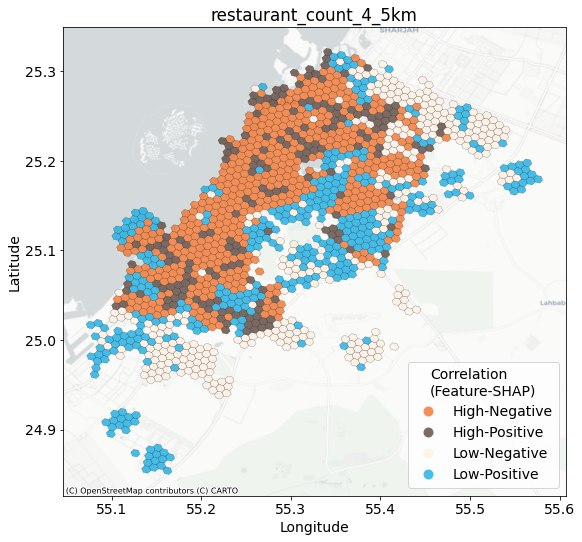

CPU times: user 2.34 s, sys: 246 ms, total: 2.58 s
Wall time: 2.09 s


In [82]:
%%time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import contextily as cx

plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1, figsize=(9, 9))
print(selected_feature)
# High-Negative, High-Positive, Low-Negative, Low-Positive
colorlist = ['#f3742e','#5c473e', '#fef1e4','#18aee5']
cmap = mcolors.ListedColormap(colorlist)

hexagon_agg_ordernumber.plot(
    column='Quadrant',         # Categorical column
    cmap=cmap,               # Colormap for categories
    alpha=0.8,
    legend=True,               # Show legend for categories
    categorical=True,          # Specify that the column is categorical
#     markersize= gdf_onefeature[selected_feature]/5,
    edgecolor = 'black',
    linewidth=0.2,
    ax=ax
)

leg = ax.get_legend()
leg.set_bbox_to_anchor((1,0.3))
leg.set_title('Correlation\n(Feature-SHAP)')
cx.add_basemap(ax, crs=gdf_onefeature.crs, source=cx.providers.CartoDB.Positron)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(selected_feature)
plt.savefig('./output/hex_spatial_SHAP_'+selected_feature+'.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Second visualization solution: Interactive map

In [5]:
# select a sample to speed up
df_shap_merged_test = df_shap_merged.head(10000)
df_shap_merged_test = df_shap_merged_test[['order_id','customer_lon','customer_lat','estimated_rent','shap_estimated_rent']]

#Converting Pandas DataFrame to GeoDataFrame
geometry = [Point(xy) for xy in zip(df_shap_merged_test.customer_lon, df_shap_merged_test.customer_lat)]
gdf = GeoDataFrame(df_shap_merged_test, crs="EPSG:4326", geometry=geometry)

In [6]:
benchmark = gdf['estimated_rent'].median()
gdf.loc[(gdf['estimated_rent']>=benchmark) & (gdf['shap_estimated_rent']>0),'Quadrant'] = 'High-Positive'
gdf.loc[(gdf['estimated_rent']>=benchmark) & (gdf['shap_estimated_rent']<=0),'Quadrant'] = 'High-Negative'
gdf.loc[(gdf['estimated_rent']<benchmark) & (gdf['shap_estimated_rent']>0),'Quadrant'] = 'Low-Positive'
gdf.loc[(gdf['estimated_rent']<benchmark) & (gdf['shap_estimated_rent']<=0),'Quadrant'] = 'Low-Negative'
gdf.Quadrant.value_counts()

Low-Negative     4410
High-Positive    2883
Low-Positive     1667
High-Negative    1040
Name: Quadrant, dtype: int64

In [8]:
%%time

# Low & Negative: Something muted, like light gray (to indicate low values and negative impact).
# Low & Positive: Light blue (to show low values but positive impact).
# High & Negative: Orange (to indicate high values with negative impact).
# High & Positive: Green (to highlight the best combination—high values and positive impact).
# cmap = mcolors.ListedColormap(['Orange', 'Green', 'lightgray', 'lightblue'])

# High-Negative, High-Positive, Low-Negative, Low-Positive
color2 = ['#f3742e','#5c473e', '#fef2e5','#18aee5']

gdf.head(1000).explore(
    column='Quadrant',  # make choropleth based on "BoroName" column
    popup=True,  # show all values in popup (on click)
    tiles="CartoDB positron",  # use "CartoDB positron" tiles #OpenStreetMap
    cmap=color2,
    style_kwds=dict(color="gray",weight='0.1',fillOpacity=0.6, style_function=lambda x: {"radius":x["properties"]["estimated_rent"]/50})
)

CPU times: user 142 ms, sys: 3.4 ms, total: 145 ms
Wall time: 611 ms
